# Turning an image into a point cloud

We try to build a GraphNN that recognize if an image contains a rectangle or a circle, representing the image as a point cloud

## Import useful stuff

In [25]:
import numpy as np
from math import *
from matplotlib import pyplot as plt 
#device_name = tf.test.gpu_device_name()
#print(device_name)

## Lets generate some data

We now generate ourself some images with a circle or a rectangle, in Gray Scale, in a random position.

We generate a single shape per figure. Each pixel is filled with a color ranging from white (0) to black (1). We use random colors according to  Min(1.0, G(0.8, 0.2)), where G(m, s) is a normal distribution centered at m and with RMS=s. Then we add some random noise as Max(0., G(0.1, 0.1)). We then  turn the image into point cloud, considering only pixels with gray index > 0.3.

Each point in the point cloud is represented as a vector of 3 numbers (iX, iY, GrayScale).

In [26]:
import cv2

addnoise=False
simple =True #single shape per figure
mixed  =False #multi shapes per figure
withBB =False  #one shape with bounding boxes

def background():
  #here one can add noise
  if addnoise:
    return np.array(np.random.rand(64,64,3)*20+100,np.uint8)
  else :
    return np.zeros((64,64,3), np.uint8)

def randomColor():
  return (int(np.random.rand()*128+128),int(np.random.rand()*128+128),int(np.random.rand()*128+128))

def drawCircle(c,x,y,r):
  img = background()
  cv2.circle(img,(x,y),r,c, -1)
  return img,x-r,y-r,x+r,y+r#return image and bounding box

def genCircle():
  return drawCircle(randomColor(),int(np.random.rand()*50)+10,int(np.random.rand()*50)+10,
                    int(np.random.rand()*6)+3)

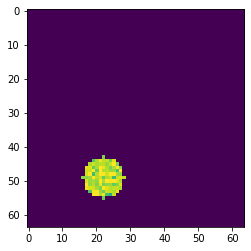

In [27]:
image = genCircle()[0]
# B&W image: sum across the colors. We want to know if pixels are 0 or anything else
image = np.sum(image, axis=-1)
# Now introduce a random gray scale as G(0.8,0.1)
image = np.random.normal(0.9,0.1,image.shape)*(image > 0)
# now clip the values between 0 and 1
image = np.minimum(np.ones(image.shape),image)
image = np.maximum(np.zeros(image.shape),image)
plt.imshow(image)
plt.show()

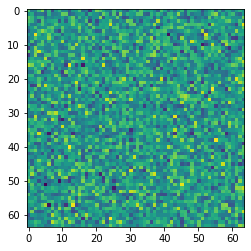

In [140]:
noise = np.random.normal(0.7,0.1, image.shape)
# now clip the values between 0 and 1
noise = np.minimum(np.ones(noise.shape),noise)
noise = np.maximum(np.zeros(noise.shape),noise)
plt.imshow(noise)
plt.show()

## Create the point cloud
Now we want to turn these images into lists of pixels, each represented as (iX, iY, GrayScale)

In [141]:
def image_to_pointcloud(image, npixel):
    point_cloud = np.array([])
    for iX in range(image.shape[0]):
        for iY in range(image.shape[1]):
            pixel = np.array([iX, iY, image[iX,iY]])
            pixel = np.reshape(pixel, (1,3))
            point_cloud = np.concatenate((point_cloud, pixel), axis = 0) if point_cloud.size else pixel
    # select the darker npixel pixels
    point_cloud= point_cloud[point_cloud[:, -1].argsort()]
    point_cloud = point_cloud[-1*npixel:]
    return point_cloud

In [142]:
Npixel = 100
point_cloud = image_to_pointcloud(image, Npixel)
point_cloud_noise = image_to_pointcloud(noise, Npixel)
print(point_cloud.shape)

(100, 3)


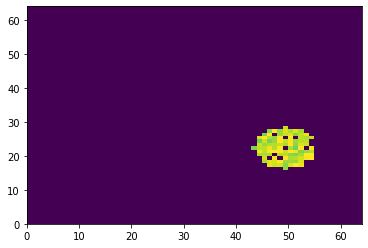

In [143]:
plt.hist2d(point_cloud[:,0], point_cloud[:,1], weights=point_cloud[:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()

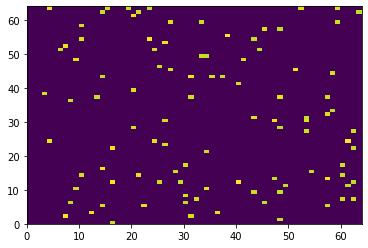

In [144]:
plt.hist2d(point_cloud_noise[:,0], point_cloud_noise[:,1], weights=point_cloud_noise[:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()

# Circles  G(0.9,0.1) vs Noise G(0.3,0.1)

In [ ]:
!git clone https://github.com/pierinim/tutorials.git
!mv tutorials/GNN_Pisa_Nov2021/data .

In [95]:
# load one file
import h5py
f = h5py.File("data/ShapeClassifier_Circle0.9_Noise0.3.h5", "r")
print(f.keys())

<KeysViewHDF5 ['A_test', 'A_train', 'X_test', 'X_train', 'Y_test', 'Y_train']>


In [96]:
X_train = np.array(f.get("X_train"))
print(X_train.shape)
ix = X_train[:,:,0]
iy = X_train[:,:,1]
grayscale = X_train[:,:,2]
# ground truth
Y_train = np.array(f.get("Y_train"))
f.close()

(700, 100, 3)


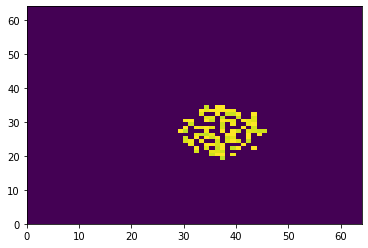

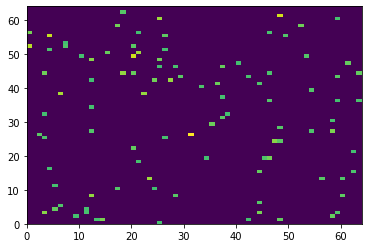

In [97]:
plt.hist2d(X_train[np.argmax(Y_train),:,0], X_train[np.argmax(Y_train),:,1], weights=X_train[np.argmax(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()
plt.hist2d(X_train[np.argmin(Y_train),:,0], X_train[np.argmin(Y_train),:,1], weights=X_train[np.argmin(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()

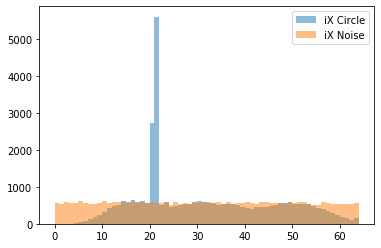

In [88]:
circle = ix[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = ix[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iX Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iX Noise", alpha=0.5)
plt.legend()
plt.show()

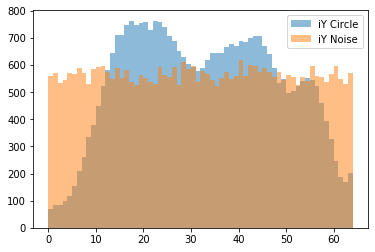

In [89]:
circle = iy[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = iy[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iY Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iY Noise", alpha=0.5)
plt.legend()
plt.show()

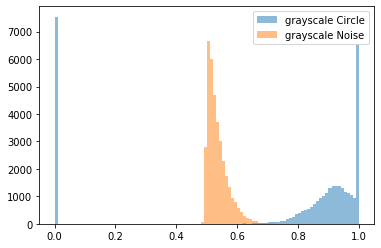

In [90]:
circle = grayscale[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = grayscale[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=100, range=(0.,1.), label="grayscale Circle", alpha=0.5)
plt.hist(noise, bins=100, range=(0.,1.), label="grayscale Noise", alpha=0.5)
plt.legend()
plt.show()

# Circles  G(0.9,0.1) vs Noise G(0.7,0.1)

In [134]:
# load one file
import h5py
f = h5py.File("data/ShapeClassifier_Circle0.9_Noise0.7.h5", "r")
print(f.keys())

<KeysViewHDF5 ['A_test', 'A_train', 'X_test', 'X_train', 'Y_test', 'Y_train']>


In [135]:
X_train = np.array(f.get("X_train"))
print(X_train.shape)
ix = X_train[:,:,0]
iy = X_train[:,:,1]
grayscale = X_train[:,:,2]
# ground truth
Y_train = np.array(f.get("Y_train"))
f.close()

(700, 100, 3)


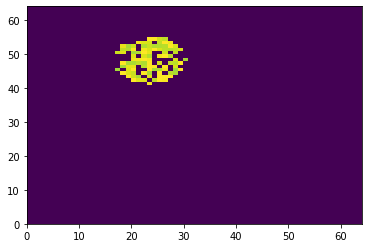

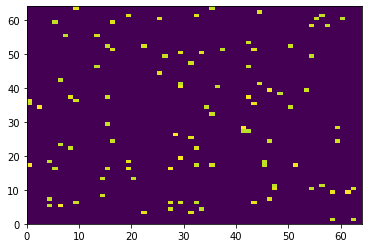

In [136]:
plt.hist2d(X_train[np.argmax(Y_train),:,0], X_train[np.argmax(Y_train),:,1], weights=X_train[np.argmax(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()
plt.hist2d(X_train[np.argmin(Y_train),:,0], X_train[np.argmin(Y_train),:,1], weights=X_train[np.argmin(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()

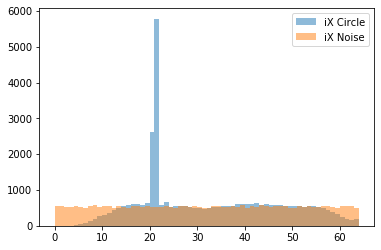

In [137]:
circle = ix[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = ix[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iX Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iX Noise", alpha=0.5)
plt.legend()
plt.show()

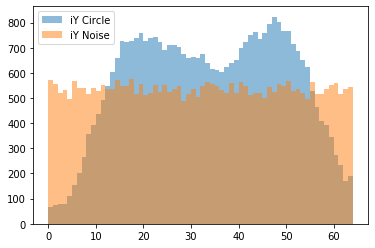

In [138]:
circle = iy[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = iy[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iY Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iY Noise", alpha=0.5)
plt.legend()
plt.show()

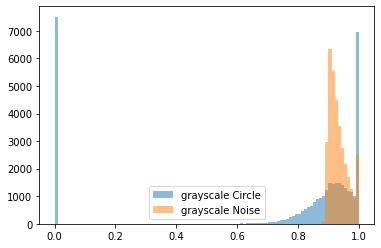

In [139]:
circle = grayscale[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = grayscale[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=100, range=(0.,1.), label="grayscale Circle", alpha=0.5)
plt.hist(noise, bins=100, range=(0.,1.), label="grayscale Noise", alpha=0.5)
plt.legend()
plt.show()

# Circles  G(0.9,0.1) vs Rectangle G(0.7,0.1)

In [104]:
# load one file
import h5py
f = h5py.File("data/ShapeClassifier_Circle0.9_Rectangle0.7.h5", "r")
print(f.keys())

<KeysViewHDF5 ['A_test', 'A_train', 'X_test', 'X_train', 'Y_test', 'Y_train']>


In [105]:
X_train = np.array(f.get("X_train"))
print(X_train.shape)
ix = X_train[:,:,0]
iy = X_train[:,:,1]
grayscale = X_train[:,:,2]
# ground truth
Y_train = np.array(f.get("Y_train"))
f.close()

(700, 100, 3)


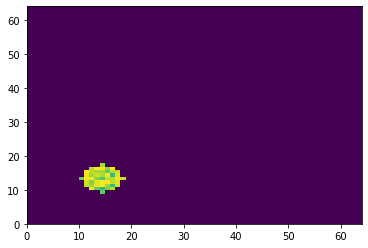

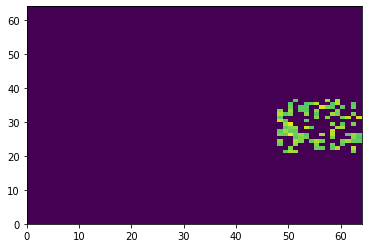

In [106]:
plt.hist2d(X_train[np.argmax(Y_train),:,0], X_train[np.argmax(Y_train),:,1], weights=X_train[np.argmax(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()
plt.hist2d(X_train[np.argmin(Y_train),:,0], X_train[np.argmin(Y_train),:,1], weights=X_train[np.argmin(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()

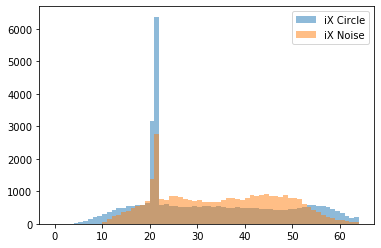

In [107]:
circle = ix[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = ix[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iX Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iX Noise", alpha=0.5)
plt.legend()
plt.show()

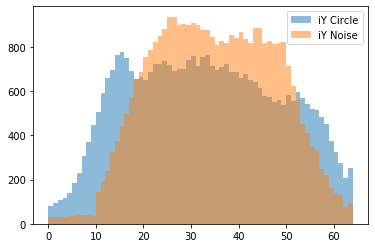

In [108]:
circle = iy[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = iy[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iY Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iY Noise", alpha=0.5)
plt.legend()
plt.show()

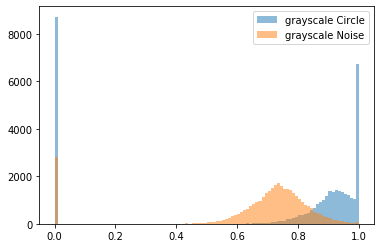

In [109]:
circle = grayscale[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = grayscale[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=100, range=(0.,1.), label="grayscale Circle", alpha=0.5)
plt.hist(noise, bins=100, range=(0.,1.), label="grayscale Noise", alpha=0.5)
plt.legend()
plt.show()

# Circles  G(0.9,0.1) vs Rectangle G(0.9,0.1)

In [110]:
# load one file
import h5py
f = h5py.File("data/ShapeClassifier_Circle0.9_Rectangle0.9.h5", "r")
print(f.keys())

<KeysViewHDF5 ['A_test', 'A_train', 'X_test', 'X_train', 'Y_test', 'Y_train']>


In [111]:
X_train = np.array(f.get("X_train"))
print(X_train.shape)
ix = X_train[:,:,0]
iy = X_train[:,:,1]
grayscale = X_train[:,:,2]
# ground truth
Y_train = np.array(f.get("Y_train"))
f.close()

(700, 100, 3)


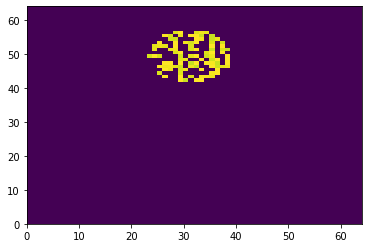

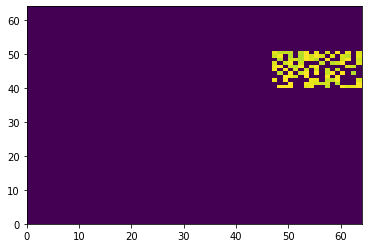

In [112]:
plt.hist2d(X_train[np.argmax(Y_train),:,0], X_train[np.argmax(Y_train),:,1], weights=X_train[np.argmax(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()
plt.hist2d(X_train[np.argmin(Y_train),:,0], X_train[np.argmin(Y_train),:,1], weights=X_train[np.argmin(Y_train),:,2], range=((0,64),(0,64)), bins=(64,64))
plt.show()

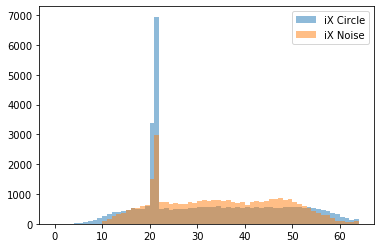

In [113]:
circle = ix[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = ix[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iX Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iX Noise", alpha=0.5)
plt.legend()
plt.show()

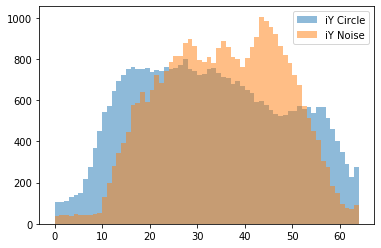

In [114]:
circle = iy[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = iy[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=64, range=(0.,64.), label="iY Circle", alpha=0.5)
plt.hist(noise, bins=64, range=(0.,64.), label="iY Noise", alpha=0.5)
plt.legend()
plt.show()

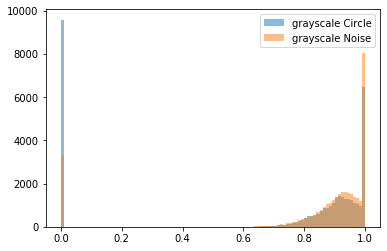

In [115]:
circle = grayscale[Y_train==1]
circle = np.reshape(circle, circle.shape[0]*circle.shape[1])
noise = grayscale[Y_train==0]
noise = np.reshape(noise, noise.shape[0]*noise.shape[1])
plt.hist(circle, bins=100, range=(0.,1.), label="grayscale Circle", alpha=0.5)
plt.hist(noise, bins=100, range=(0.,1.), label="grayscale Noise", alpha=0.5)
plt.legend()
plt.show()